# Example Solow model 


In this jupyter notebook we will specify, solve and analyse a simple Solow model in ModelFlow. 
    

In [94]:
#Required packages
import pandas as pd

# Modelflow modules
from modelclass import model
   
#for publication 
latex=0
model.widescreen()


## Specify the model 
We start by defining the logic of the Solow model in the Business Logic Language.   



In [95]:
from dataclasses import dataclass, field

@dataclass 

class fftpoc():
    '''A  silly class which is initialiced and contains a functionwhich can be called from modelflow.
    in FTT context it should initialize the FTT model and define functions which can be called. 
    '''    
    
    base_price_coal : float =  100 
    base_price_oil  : float =  200 
    base_year       : int   = 2019 
    pricegrowth     : float =  0.01 
        
    def get_prices(self,year,labor=100):
        current_price_coal = self.base_price_coal* (1+self.pricegrowth)**(year-self.base_year) 
        current_price_oil  = self.base_price_oil * (1+self.pricegrowth)**(year-self.base_year) 
        return current_price_coal, current_price_oil,labor 
        
this_instance = fftpoc()   # make an instance 

get_prices =  this_instance.get_prices   # Fefine a function which can be included in the modelflow business languiage. 
get_prices(2023) # test that we get a number 

(104.060401, 208.120802, 100)

In [96]:
this_instance

fftpoc(base_price_coal=100, base_price_oil=200, base_year=2019, pricegrowth=0.01)

In [97]:
def labor_dif(growth,last):
    return growth*last

In [98]:
def answer(growth):
    return 42,34

In [99]:

fsolow2 = '''\
Income          = a  * Capital**alfa * Labor **(1-alfa) 
Consumption     = (1-saving_rate)  * Income 
Investment      = Income - Consumption   
diff(Capital)   = Investment-Depreciation_rate * Capital(-1)
diff(Labor)     = labor_dif(Labor_growth,Labor(-1))  
Capital_intensity = Capital/Labor 
ibh,b = answer(Labor_growth)
horse =  ibh *b 
coal_price, oil_price, extralabor = get_prices(year,labor)
'''

## Create a model class instance

After defining the Business Logic Language and storing it in the variable 'fsolow', we create a class instance called msolow. 

In [100]:
msolow = model.from_eq(fsolow2,modelname='Solow model',funks=[labor_dif,answer,get_prices])

In [101]:
msolow.print_model

FRML <> INCOME          = A  * CAPITAL**ALFA * LABOR **(1-ALFA)  $
FRML <> CONSUMPTION     = (1-SAVING_RATE)  * INCOME  $
FRML <> INVESTMENT      = INCOME - CONSUMPTION    $
FRML <> CAPITAL=CAPITAL(-1)+(INVESTMENT-DEPRECIATION_RATE * CAPITAL(-1))$
FRML <> LABOR=LABOR(-1)+(LABOR_DIF(LABOR_GROWTH,LABOR(-1)))$
FRML <> CAPITAL_INTENSITY = CAPITAL/LABOR  $
FRML <> IBH,B = ANSWER(LABOR_GROWTH) $
FRML <> HORSE =  IBH *B  $
FRML <> COAL_PRICE, OIL_PRICE, EXTRALABOR = GET_PRICES(YEAR,LABOR) $


## Create some data 

To show what Modelflow can do, we create a Pandas dataframe with input data. And print the first 5 out of 300 observations.  

In [102]:
N = 300  
df = pd.DataFrame({'LABOR':[100]*N,
                   'CAPITAL':[100]*N, 
                   'ALFA':[0.5]*N, 
                   'A': [1]*N, 
                   'DEPRECIATION_RATE': [0.05]*N, 
                   'LABOR_GROWTH': [0.01]*N, 
                   'SAVING_RATE':[0.05]*N,
                   'YEAR': [2020 + i for i in range(N)] })
df.head(2) #this prints out the first 5 rows of the dataframe

,LABOR,CAPITAL,ALFA,A,DEPRECIATION_RATE,LABOR_GROWTH,SAVING_RATE,YEAR
0,100,100,0.5,1,0.05,0.01,0.05,2020
1,100,100,0.5,1,0.05,0.01,0.05,2021


## Run the model 

In [103]:
result = msolow(df,keep='Baseline') # The model is simulated for all years possible 
result.head(5)

,LABOR,CAPITAL,ALFA,A,DEPRECIATION_RATE,LABOR_GROWTH,SAVING_RATE,YEAR,INCOME,EXTRALABOR,CAPITAL_INTENSITY,HORSE,INVESTMENT,COAL_PRICE,OIL_PRICE,B,IBH,CONSUMPTION
0,100.000000,100.000000,0.5,1.0,0.05,0.01,0.05,2020.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1,101.000000,100.025580,0.5,1.0,0.05,0.01,0.05,2021.0,100.511609,101.000000,0.990352,1428.0,5.025580,102.010000,204.020000,34.0,42.0,95.486029
2,102.010000,100.076226,0.5,1.0,0.05,0.01,0.05,2022.0,101.038487,102.010000,0.981043,1428.0,5.051924,103.030100,206.060200,34.0,42.0,95.986562
3,103.030100,100.151443,0.5,1.0,0.05,0.01,0.05,2023.0,101.580575,103.030100,0.972060,1428.0,5.079029,104.060401,208.120802,34.0,42.0,96.501546
4,104.060401,100.250762,0.5,1.0,0.05,0.01,0.05,2024.0,102.137821,104.060401,0.963390,1428.0,5.106891,105.101005,210.202010,34.0,42.0,97.030930


## Create a scenario and run again 

:::{margin} **dataframe.upd**
When importing modelclass all pandas dataframes are enriched with a a handy way to create a new pandas dataframe with updated series. 

In this case df.upd will create a a new dataframe with updated LABOR_GROWTH 

For additional explanation look [here](../../howto/update/model%20update.ipynb)
:::

In [104]:
dfscenario = df.upd('LABOR_GROWTH + 0.002')  # create a new dataframe, increase LABOR_GROWTH by 0.002
scenario   = msolow(dfscenario,keep='Higher labor growth ') # simulate the model 

## Now the results are also embedded in msolow.  


 - ```.basedf``` contains the first run of the model 
 - ```.lastdf``` contains the last run of the model 
 
 Also in this case the keyword ```keep``` is used. This causes the results to be  stored in a dictionary ```msolow.keep_solutions```. This can be useful when comparing several scenarios. 
 

## Inspect results  

### Using the [ ] operator 

We can select the variables of interest with wildcards. This will operate the results stored in ```basedf``` and ```.lastdf```

#### Look at all endogenous variables

### The logical stucture 
Now the model has been analyzed, and the structure can be displayed.

You will find more on the logical structure [here](../../howto/structure/Logical_structure.ipynb)

#### Model structure

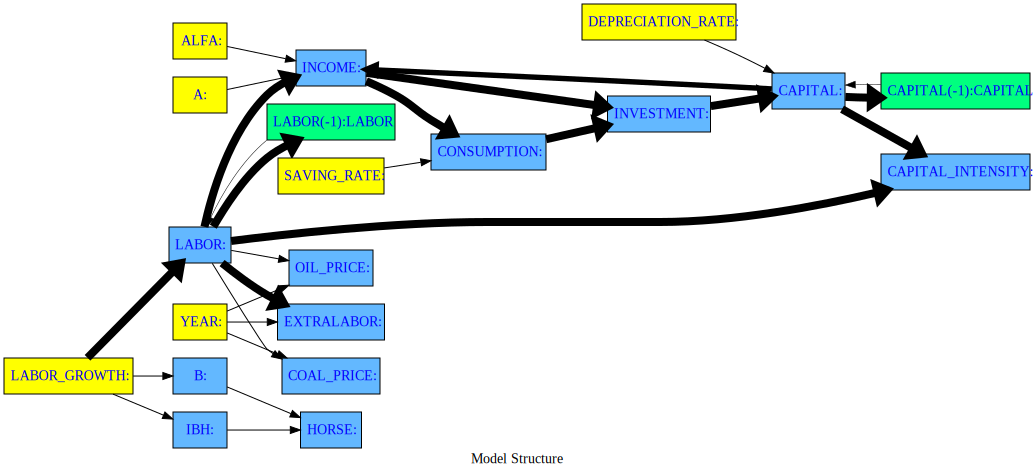

In [105]:
msolow.drawmodel( title="Model Structure", png=latex,size=(15,15))

#### Adjacency matrix

Another way to illustrate the dependency graph is an adjacency matrix. 

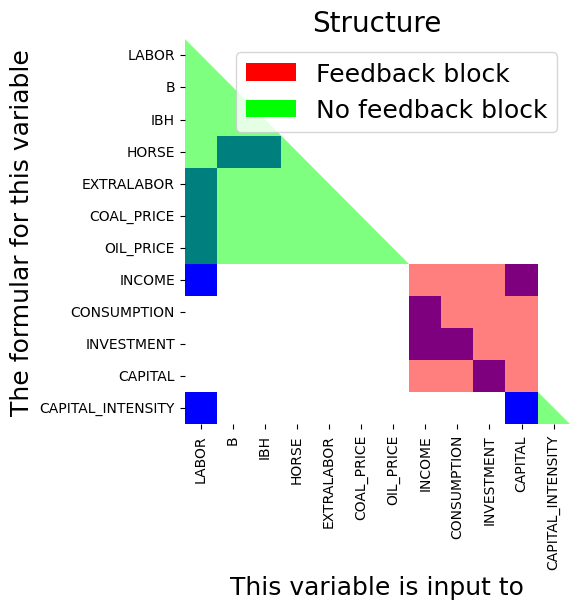

In [106]:
msolow.plotadjacency();

The variables  ['INVESTMENT', 'CONSUMPTION', 'CAPITAL', 'INCOME'] in the red area are the core of the model and has to be solved as a system. 

LABOR is the prolog and can be calculated before the core is solved. While CAPITAL_INTENSE is the epilog which can be calculated after the core is solved. 

Many models comform to this pattern. And for solving purpose a model is divided into a prolog, core and an epilog. Even if the core is actually consistent of several strong components. 

(solow-python-code)=
### The python function used to solve the model
In order to solve the model Modelflow will generate a python function which implements the model. The user will hopeful  newer have to relate to the generated python code. **The point of modelflow is, that the user has to relate to the specification of the business logic, not the implementation in code**  

In [107]:
print(msolow.make_los_text)

def make_los(funks=[],errorfunk=None):
    import time
    import tqdm
    from numba import jit
    from modeluserfunk import jit, recode
    from modelBLfunk import array, classfunk, clognorm, exp, gamma, inspect, jit, lifetime_credit_loss, log, logit, logit_inverse, lognorm, matrix, mv_opt, mv_opt_prop, norm, normcdf, qgamma, sqrt, sum_excel, transpose
    labor_dif = funks[0]
    answer = funks[1]
    get_prices = funks[2]
    def prolog0(values,outvalues,row,alfa=1.0):
        try :
            pass
            values[row,0]=values[row-1,0]+(labor_dif(values[row,5],values[row-1,0]))
            pass  # B
            values[row,16],values[row,15]=answer(values[row,5])
            values[row,11]=values[row,16]*values[row,15]
            pass  # EXTRALABOR
            values[row,13],values[row,14],values[row,9]=get_prices(values[row,7],values[row,0])
            pass  # OIL_PRICE
        except :
            errorfunk(values,sys.exc_info()[2].tb_lineno,overhead=12,overeq=0)
         